# Language Translation

* Objective:

Detect Foreign Languages in dataset and perform machine translation backed by Hugging Face models. The quality of machine translation via cloud services has come a very long way and produces high quality results. This notebook shows how the models from Hugging Face give developers a reasonable alternative for local machine translation.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd '/content/drive/MyDrive'

Mounted at /content/drive
/content/drive/MyDrive


In [2]:
import re
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

tqdm.pandas()

In [3]:
dataset = pd.read_excel('./data/merged_clean_data_with_chineese.xlsx')

dataset.isna().sum()

short_description              0
description                    0
caller                         0
group                          0
char_length                    0
word_length                    0
short_char_length              0
short_word_length              0
description_keywords          12
short_description_keywords    39
group_code                     0
char_length_bins               0
cleaned_description           57
cleaned_short_description     50
cleaned_char_length            0
cleaned_word_length            0
cleaned_short_char_length      0
cleaned_short_word_length      0
merged_description             0
dtype: int64

In [4]:
dataset.sample(7)

,short_description,description,caller,group,char_length,word_length,short_char_length,short_word_length,description_keywords,short_description_keywords,group_code,char_length_bins,cleaned_description,cleaned_short_description,cleaned_char_length,cleaned_word_length,cleaned_short_char_length,cleaned_short_word_length,merged_description
8009,unable to connect to wifi from a hotel // dell...,unable to connect to wifi from a hotel // dell...,imoelsap gxdwkimv,GRP_0,51,11,51,11,unable to connect to wifi,unable to connect to wifi,0,6,unable connect wifi hotel dell,unable connect wifi hotel dell,30,5,30,5,unable connect wifi hotel dell
4049,job hr_payroll_na_u2 failed in job_scheduler a...,received from: monitoring_tool@company.com\n\n...,bpctwhsn kzqsbmtp,GRP_10,112,11,70,8,payroll,payroll,2,13,job hr payroll na u fail job scheduler,job hr payroll na u fail job scheduler,38,8,38,8,job hr payroll na u fail job scheduler
2527,crm issue for iphone,\n\nreceived from: zfburidj.jmilguev@gmail.com...,zfburidj jmilguev,GRP_0,153,27,20,4,company crm address,crm issue for iphone,0,18,try set crm iphone ask company crm address,crm issue iphone,42,8,16,3,issue try set crm iphone ask company crm address
4857,vpn,\n\nreceived from: marhty.financial@company.co...,oujvmgeq spobcflw,GRP_0,213,31,3,1,start vpn,vpn,0,22,get follow error try start vpn also try instal...,vpn,68,13,3,1,get follow error try start vpn also try instal...
8094,logon to server HostName_583 not possible,logon to server HostName_583 not possible - se...,smpijawb eawkpgqf,GRP_12,85,16,41,6,logon to server HostName,logon to server HostName,4,10,logon server hostname possible server loop sc...,logon server hostname possible,50,7,31,4,logon server hostname possible server loop sc...
4206,application response time (other network resou...,our colleagues have opened a ticket about the ...,gwfozprc kldrsnze,GRP_0,150,25,65,8,sales org,application response time,0,17,colleague open ticket issue spain sale org po...,application response time network resource wor...,73,12,56,7,application response time network resource wor...
5540,printer driver installation,name:rohntyub dfhtyuison\nlanguage:\nbrowser:m...,zstkagwu jlyrhdcf,GRP_0,296,38,27,3,microsoft internet explorer email,printer driver installation,0,30,issue print regular printer get error say page...,printer driver installation,90,14,27,3,installation issue print regular printer get e...


<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Detect Languages in Merged Descriptions using <a href="https://fasttext.cc/docs/en/language-identification.html">fastText language identification model</a>
</ul></h3>

In [5]:
# download pre-trained language detection model

! wget -O lid.176.bin https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

--2021-09-19 10:27:42--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131266198 (125M) [application/octet-stream]
Saving to: ‘lid.176.bin’

lid.176.bin         100%[===================>] 125.18M  23.4MB/s    in 5.9s    

2021-09-19 10:27:49 (21.3 MB/s) - ‘lid.176.bin’ saved [131266198/131266198]



In [6]:
! pip -q install fasttext
import fasttext

# monkey-patch to suppress 'load_model warning from fasttext'
fasttext.FastText.eprint = lambda x: None

In [7]:
# fastText pre-trained language identification model
# (less latency & more accurate)


# lid (Language identification modeel which can recognize 176 languages)
path_to_pretrained_model = './lid.176.bin'
lang_model = fasttext.load_model(path_to_pretrained_model)
test = ["+86 Hi there", "c'est", "bitte", "+81"]
pred = lang_model.predict(test)
pprint(test)
pprint([i[0] for i in pred[0]], compact=True)
pprint([i[0] for i in pred[1]], compact=True)

['+86 Hi there', "c'est", 'bitte', '+81']
['__label__en', '__label__fr', '__label__de', '__label__zh']
[0.72783333, 1.0000362, 0.9995301, 0.18863995]


In [8]:
descriptions = dataset.merged_description.tolist()
len(descriptions)

8499

In [9]:
pred_descriptions = lang_model.predict(descriptions)
lang_descriptions = [re.sub("__label__", "", i[0]) for i in pred_descriptions[0]]
lang_descriptions_conf = [i[0] for i in pred_descriptions[1]]

In [10]:
# detected languages with various confidences
pprint({i[0] for i in pred_descriptions[0]}, compact=True)

{'__label__bs', '__label__ca', '__label__cs', '__label__da', '__label__de',
 '__label__en', '__label__eo', '__label__es', '__label__eu', '__label__fa',
 '__label__fi', '__label__fr', '__label__hi', '__label__hr', '__label__hu',
 '__label__id', '__label__it', '__label__ja', '__label__jv', '__label__kn',
 '__label__mk', '__label__ml', '__label__nl', '__label__no', '__label__pl',
 '__label__pt', '__label__ro', '__label__ru', '__label__sh', '__label__sl',
 '__label__sv', '__label__th', '__label__tl', '__label__tr', '__label__ur',
 '__label__zh'}


In [11]:
dataset['language'] = lang_descriptions
dataset['language_confidence'] = lang_descriptions_conf

# language predictions and associated confidence of prediction
dataset.sample(7)[['merged_description', 'language', 'language_confidence']]

,merged_description,language,language_confidence
5305,arcve tool scanner work upgrade open text imag...,en,0.756285
7759,install printer maintenance area,en,0.520235
2527,issue try set crm iphone ask company crm address,en,0.937188
4838,unable login sid,da,0.146170
4589,need cute pdf instal,en,0.742032
3827,issue one note workbook share open web view ge...,en,0.688904
368,daten kann nicht heruntergeladen werden die ma...,de,0.996929


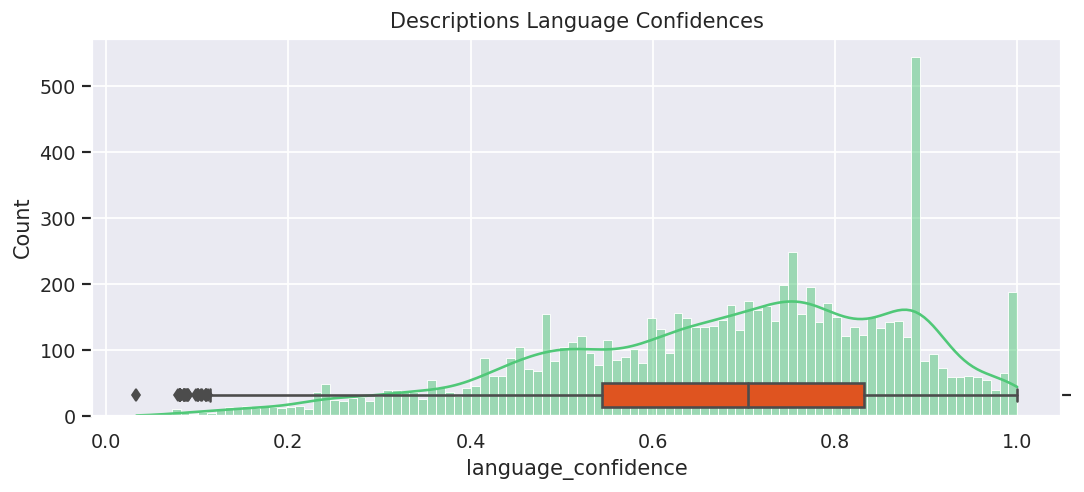

In [12]:
sns.set()
plt.figure(figsize=(10, 4), dpi=125)
ax = sns.histplot(x=dataset.language_confidence, bins=100, kde=True, color='#50C878')
ax_ = ax.twinx()
sns.boxplot(x=dataset.language_confidence, color='#FF4500')
ax_.set(ylim=(-.7, 12))
plt.title('Descriptions Language Confidences')
plt.show()

In [13]:
# check some predictions with less confidence
dataset[(dataset.language != 'en') & (dataset.language_confidence < 0.6)][['merged_description', 'language', 'language_confidence']]

,merged_description,language,language_confidence
2,ca nt log vpn,da,0.132258
4,skype error,ja,0.081046
12,unable login hr tool sgxqsuojr xwbesorf card,zh,0.104415
14,unable open payslip,fr,0.264625
20,unable check payslip,fr,0.172341
...,...,...,...
8396,security error reisekosten abrechnung programdnty,de,0.254021
8413,langsamer rechner uberprufung niptbwdq,de,0.437996
8416,bluetooth keybankrd defekt dardabthyr,sv,0.245299
8426,new able login system user vvrtgwildj name joh...,de,0.548117


In [14]:
# check some predictions with less confidence
dataset[(dataset.language != 'en') & (dataset.language_confidence > 0.6)][['merged_description', 'language', 'language_confidence']]

,merged_description,language,language_confidence
223,probleme bluescreen hallo es ist erneut passie...,de,0.997537
251,reset password bitte passwort fr mail zurckset...,de,0.870327
255,probleme mit laufwerk laeusvjo,de,0.992616
265,hallo netweaver funktioniert nicht mehr bzw ka...,de,0.999658
270,neues passwort fur accountname tgryhu hgygrtui...,de,0.992012
...,...,...,...
8424,kann setzten ich wei mein erp passwort nicht m...,de,0.998999
8438,fur die up lapel druckt nicht richtig der druc...,de,0.999573
8466,send friday nwfodmhc exurcwkm subject wg die...,de,0.969530
8470,"电脑开机开不出来 to 小贺,早上电脑开机开不出来",zh,0.924405


* We can clearly see that low confidence predictions are not right actually foreign-language but interpreted as such because of out of dictionary words and caller names present in the text. So, we overwrite predictions with confidence less than 0.6 back to english

In [15]:
dataset.loc[(dataset.language != 'en') & (dataset.language_confidence < 0.6), 'language'] = 'en'

In [16]:
dataset[(dataset.language != 'en') & (dataset.language_confidence < 0.6)]  # overwritten

,short_description,description,caller,group,char_length,word_length,short_char_length,short_word_length,description_keywords,short_description_keywords,group_code,char_length_bins,cleaned_description,cleaned_short_description,cleaned_char_length,cleaned_word_length,cleaned_short_char_length,cleaned_short_word_length,merged_description,language,language_confidence


In [17]:
dataset.language.value_counts()

en    7961
de     485
zh      32
pt       8
fr       3
tl       2
fi       2
es       2
ca       2
it       1
pl       1
Name: language, dtype: int64

In [18]:
dataset.to_excel('./data/merged_clean_data_with_lang_pred.xlsx', index=None)

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Translation using txtai pipelines which use <a href="https://huggingface.co/models?search=Helsinki-NLP%2Fopus-mt">hugging-face language translation models</a> as backend</span></strong>
</ul></h3>

In [19]:
# Install `txtai` and all dependencies. Since this notebook is using optional pipelines
# we need to install the pipeline extras package.

!pip -q install git+https://github.com/neuml/txtai#egg=txtai[pipeline]

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [20]:
# The pipeline has logic to detect the input language,
# load the relevant model that handles translating from source to # target language and return results.
# The translation pipeline also has built-in logic to handle splitting large text
# blocks into smaller sections the models can handle.


from txtai.pipeline import Translation

# Create translation model
translate = Translation()

In [21]:
# The translation quality overall is very high
# Machine translation has made giant leaps and strides the last couple of years
# These models are a solid alternative to cloud translation services if translating on local servers is preferred.

translation = translate("Bonjour, Ca va?", "en")

In [22]:
translation

'Hello, are you okay?'

In [23]:
def translate_foreign_langauges(row):
    original_descr = row.merged_description
    translated_descr = original_descr
    if row.language != 'en':
        if len(original_descr) > 512:
            # pre-trained models only support sequences of length < 512
            orinal_descr = original_descr[:512]
        translation = translate(original_descr, "en")
        if len(translation) > 0:
            translated_descr = translation

    row['translated_description'] = str(translated_descr.strip())
    return row

In [24]:
translated_dataset = dataset.progress_apply(translate_foreign_langauges, axis=1)

100%|██████████| 8499/8499 [17:19<00:00,  8.18it/s]


In [27]:
# sample translations
translated_dataset[translated_dataset.language != 'en'].sample(20)[['merged_description', 'translated_description']]

,merged_description,translated_description
2285,probleme mit portal franjuz urbghty,problems with portal franjuz urbghty
3747,telefon gigaset m mit der durchwahl akku halt...,phone gigaset m with the dialing battery stop ...
270,neues passwort fur accountname tgryhu hgygrtui...,new password for accountname tgryhu hgygrtui p...
6488,login error hallo zusammen beim einloggen mit ...,login error hello together with the login with...
6356,setup new ws instandsetzung,setup new ws repair
2085,lauft sehr langsam werk germany nicht mehr akt...,runs very slow work germany no longer current ...
6780,set back ts document status dispo avfertigungs...,set back ts document status dispo avproduktion...
5447,enterprise search connector u work mit freundl...,enterprise search connector u work with friend...
8229,new request team anbei ein investmentantrag fu...,new request team at an investment application ...
4357,terminal bei iso konnen eu tool keine zeichnu...,terminal at iso konnen eu tool no more drawing...


In [28]:
translated_dataset.to_excel('./data/clean_data_tranlsated.xlsx')